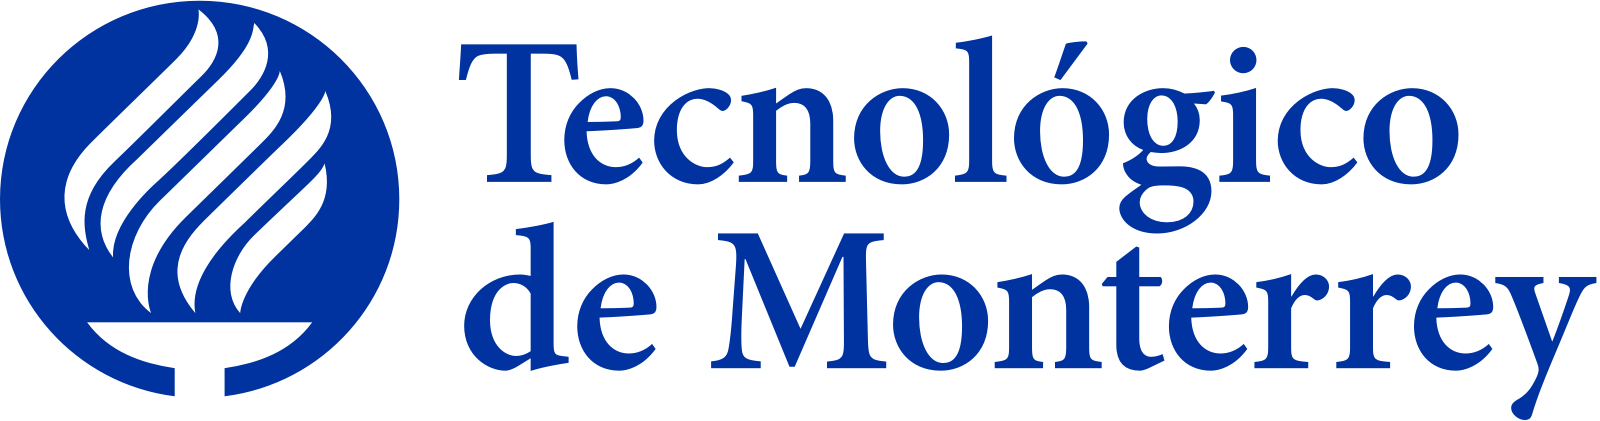

---
# Instituto Tecnológico y de Estudios Superiores de Monterrey


## **Capstone Project (Team #49)**


### **Stage 3.** Baseline


#### *Author:* Julia Gabriela Pinedo -- A01795315

#### *Professor:* Dr. Grettel Barceló Alonso
#### *Project Advisor:* Dr. Guillermo Mota Medina

---

## Table of Contents
1. [Introduction](#intro)
2. [Algorithm](#algo)
3. [Features](#fe)
4. [Under/Overfitting](#under)
5. [Metrics](#met)
6. [Performance](#per)
7. [Conclusion](#conclusion)
8. [References](#references)

---

# Introduction <a class="anchor" id="intro" ></a>

Following the improvements established in **Stage 1**, the modeling environment in Gazebo Harmonic and the ROS 2 Jazzy bridge were fully stabilized (**Figure 1**). The simulation now delivers consistent, high-frequency telemetry streams for both the robot and the box, enabling the generation of structure, learning-ready data suitable for Reinforcement Learning.

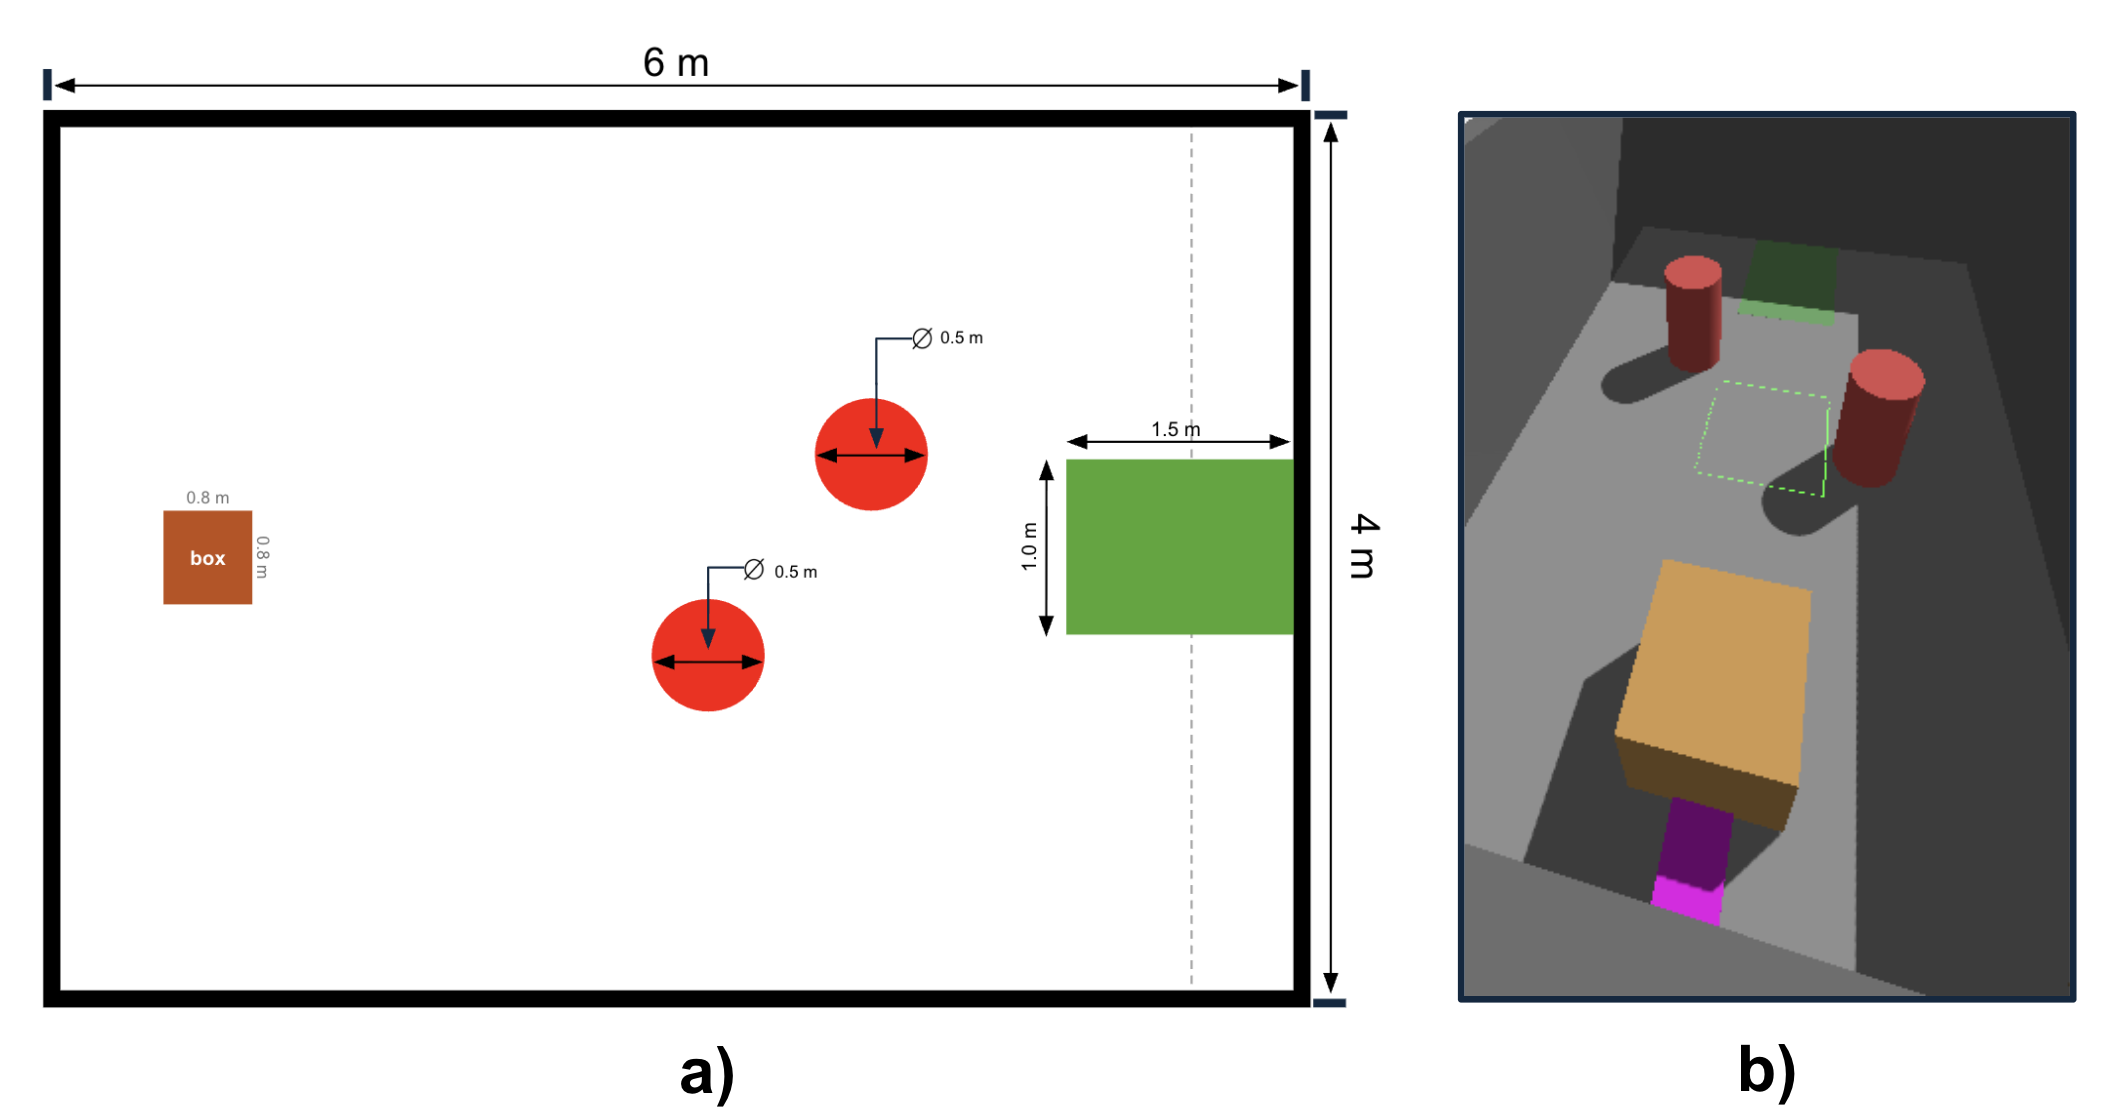
**Figure 1.** Simulation environment. a) Diagram of the arena, b) Arena modeled and simulated in Gazebo.

The goal-driven spawn geometry, curriculum-based obstacle setup, and telemetry robustness implemented earlier ensure that every episode produces coherent, noise-reduced sensor readings. These modifications effectively eliminated missing or null poses, allowing the pipeline to focus on policy optimization rather than data integrity. 

During **Stage 2**, the setup transitioned into a Reinforcement Learning system, in which the agent continually generates its own experience through the sequence of transitions:

$(s_{t},a_{t},r_{t},s_{t+1})$

as it learns to push the box toward the goal. 

Since the data is generated *online*, the preparation phase does not consist of classical cleaning or imputation. Instead, the focus lies in real-time feature scaling and normalization within the agent's loop to maintain numerical stability during the Q-value updates. These transformations are executed in memory at every timestep before computing the next action.

- **MinMax Scaler:**

---
```python
class RunningMinMax:
    """
    Online MinMaxScaler for known physical ranges.
    If (lo, hi) are provided, uses them as fixed bounds; otherwise adapts online.
    """
    def __init__(self, lo=None, hi=None):
        self.fixed = (lo is not None) and (hi is not None)
        self.lo = np.array(lo, dtype=float) if lo is not None else None
        self.hi = np.array(hi, dtype=float) if hi is not None else None

    def partial_fit(self, x):
        """Update running min/max statistics"""
        x = np.asarray(x, dtype=float)
        if self.fixed:
            return  # Don't update if using fixed bounds
        if self.lo is None:
            self.lo = x.copy()
            self.hi = x.copy()
        else:
            self.lo = np.minimum(self.lo, x)
            self.hi = np.maximum(self.hi, x)

    def transform(self, x):
        """Scale to [0, 1] range"""
        x = np.asarray(x, dtype=float)
        lo, hi = self.lo, self.hi
        # Avoid division by zero
        den = np.where((hi - lo) == 0.0, 1.0, (hi - lo))
        return np.clip((x - lo) / den, 0.0, 1.0)
```
---

- **Standard Scaler:**

---
```python
class RunningStandard:
    """
    Online StandardScaler using Welford's algorithm for numerical stability.
    Computes running mean and variance without storing all samples.
    """
    def __init__(self, dim):
        self.n = 0
        self.mean = np.zeros(dim, dtype=float)
        self.M2 = np.zeros(dim, dtype=float)  # Sum of squared differences

    def partial_fit(self, x):
        """Update running mean and variance"""
        x = np.asarray(x, dtype=float)
        if self.n == 0:
            self.mean = np.zeros_like(x)
            self.M2 = np.zeros_like(x)
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2

    def transform(self, x):
        """Standardize to zero mean, unit variance"""
        x = np.asarray(x, dtype=float)
        if self.n <= 1:
            return x  # Not enough samples yet
        var = self.M2 / (self.n - 1)
        std = np.where(var == 0.0, 1.0, np.sqrt(var))
        return (x - self.mean) / std
```
---

This approach guarantees that, regardless of how the robot moves or how the simulation evolves, all input dimensions remain numerically comparable, preventing any single sensor from dominating the update process. As a result, the RL agent operates over a well-balanced and dynamically normalized feature space, ensuring stable convergence and reproducible learning behavior.

# Algorithm <a class="anchor" id="algo" ></a>

Since our agent interacts *online* with a fully instrumented, simulated control task, the observations are **structured, numeric, and sequential** (poses, velocities, IMU, distances), and do not make part of an offline dataset. This configuration enables the agent to continuously generate its own experiences with the Gazebo + ROS2 environment, capturing the dynamic nature of decision-making under uncertainty.

We already followed this standard procedure in **Stage 2**, where the agent's state and action representations were defined and stabilized:

- **State/action size:** We discretized ~13 real-time features into a manageable finite state space (~2.1M bins after coarse 3-bin quantization) and a small discrete action set (4 actions). This configuration makes the problem computationally tractable while preserving the essential dynamics of the task.
- **Relevant features and online preprocessing:** The pipeline (*as discussed in the Introduction*) applies **Min-Max** to spatial variables, **Standardization** to dynamics/IMU, and **encodes** binary flags (contact, in-goal). This normalization ensures all dimensions remain numerically comparable, promoting stable convergence.
- **Interpretability:** Each $Q(s,a)$ entry maps directly to a physical situation, allowing a straightforward inspection of reward shaping, exploration effects, and atypical agent behaviors.

In contrast to conventional machine learning algorithms, where the models learn from a fixed offline dataset of labeled examples, Reinforcement Learning involves an agent that learns online *through direct interaction* with its environment. As previously discussed, **learning is driven by sequential decision-making under uncertainty**, where each action influences future states and rewards. Since the agent generates its own experience through transitions $(s_{t},a_{t},r_{t},s_{t+1})$, it aligns perfectly with the **Markov Decision Process (MDP)** formulation and a **value-learning framework** [13][14].

The environment in Gazebo exhibits partially deterministic dynamics governed by rigid-body physics and sensor noise, making the transition probabilities $P(s'|s,a)$ stable yet not perfectly predictable. Moreover, since the control space is discrete and the number of possible transitions is finite, the **tabular** representation ensures convergence to the optimal policy without the need for function approximation, which would otherwise introduce bias or instability.

For these reasons, **Tabular Q-Learning** was selected as the baseline algorithm. It directly estimates the optimal action-value function $Q*(s,a)$ using the **Bellman optimality update**, which iteratively refines expected returns for each state-action pair according to **Equation 1**:

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) +
\alpha [ r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) ]... (1)$

This off-policy formulation ensures convergence in finite MDPs under standard assumptions such as sufficient exploration and decaying step sizes. An additional advantage of the tabular approach lies in its transparency, which makes it easier to diagnose anomalies and verify that policy updates correspond to intuitive motion patterns, an insight often obscured in deep function approximators [14][15].

---
```python
class QAgent:
    """
    Tabular Q-learning with ε-greedy exploration.
    
    Q-learning update rule:
        Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
    """
    def __init__(self, n_actions=4, alpha=0.1, gamma=0.95, eps=1.0, eps_min=0.05, eps_decay=0.99):
        self.nA = n_actions
        self.alpha = alpha          # Learning rate
        self.gamma = gamma          # Discount factor
        self.eps = eps              # Exploration rate
        self.eps_min = eps_min      # Minimum exploration
        self.eps_decay = eps_decay  # Decay rate per episode
        self.Q = {}                 # Q-table: {(state, action): value}

    def _q(self, s, a):
        """Get Q-value with default 0.0 for unseen state-action pairs"""
        return self.Q.get((s, a), 0.0)

    def act(self, s):
        """ε-greedy action selection"""
        if np.random.rand() < self.eps:
            return np.random.randint(self.nA)  # Explore
        else:
            qs = [self._q(s, a) for a in range(self.nA)]
            return int(np.argmax(qs))  # Exploit

    def update(self, s, a, r, s2, done):
        """Q-learning update"""
        if done:
            target = r  # No future reward
        else:
            best_next = max(self._q(s2, a2) for a2 in range(self.nA))
            target = r + self.gamma * best_next
        
        old_q = self._q(s, a)
        self.Q[(s, a)] = old_q + self.alpha * (target - old_q)

    def decay(self):
        """Decay exploration rate"""
        self.eps = max(self.eps_min, self.eps * self.eps_decay)
    
    def save(self, path):
        """Save Q-table and hyperparameters to JSON"""
        os.makedirs(os.path.dirname(path) or '.', exist_ok=True)
        with open(path, 'w') as f:
            # Serialize state tuples as strings
            q_serializable = {f"{s}||{a}": float(v) for (s, a), v in self.Q.items()}
            json.dump({
                'Q': q_serializable,
                'params': {
                    'alpha': float(self.alpha),
                    'gamma': float(self.gamma),
                    'eps': float(self.eps),
                    'nA': int(self.nA)
                }
            }, f, indent=2)
    
    def load(self, path):
        """Load Q-table and hyperparameters from JSON"""
        with open(path, 'r') as f:
            data = json.load(f)
            self.Q = {}
            for key, val in data['Q'].items():
                s_str, a_str = key.rsplit('||', 1)
                s = eval(s_str)  # Convert string back to tuple
                a = int(a_str)
                self.Q[(s, a)] = float(val)
            params = data['params']
            self.alpha = params['alpha']
            self.gamma = params['gamma']
            self.eps = params['eps']
            self.nA = params['nA']
```
---

On the other hand, the Tabular Q-Learning agent serves as a foundational benchmark. It establishes a stable, interpretable baseline against more complex methods, opening the floor to evaluate these methods in later stages. Such progression represents a natural evolution in control-oriented RL [15]. However, scalability remains a limitation, as the state-action space may grow exponentially when multiple agents are introduced, and Tabular Q-Learning may become impractical.

In those cases, architectures such as **neural approximators** and **actor-critic** could be essential to handle continuous, high-dimensional control.

Another important factor in choosing a Tabular Q-Learning agent is **data efficiency**. As the agent continuously gathers experience, every interaction directly contributes to updating its Q-table. This online update mechanism makes Q-Learning well-suited for sample-limited environments, where collecting data (through simulated time) incurs computational costs. The $\varepsilon$-greedy policy balances exploration (discovering new strategies) and exploitation (refining known ones), a crucial trade-off when agents must learn stable control behaviors without extensive supervision.

Although this initial setup focuses on a **single-agent controller**, the same reasoning scales conceptually to **multi-agent cooperation**, where each agent maintains a local Q-table or contributes to a shared global one. In spite of that, establishing a robust tabular baseline first ensures that all subsequent improvements are both measurable and theoretically grounded.


## Global Libraries

Since ROS 2 and Gazebo are not designed to run natively in Jupyter, the RL agent logs all training artifacts online to files:

- episode metrics (`qlearn_metrics.jsonl`),
- the learned Q-table (`qtable.json`),
- step rollouts (`rollouts.csv`).

---
```python
metrics_path = os.environ.get("QLEARN_METRICS", "/tmp/qlearn_metrics.jsonl")
qtable_path = os.environ.get("QLEARN_QTABLE", "/tmp/qtable.json")
rollouts_csv = os.environ.get("ROLLOUTS_CSV", "/tmp/rollouts.csv")
_ensure_rollouts_csv(rollouts_csv)
    
node.get_logger().info("=" * 70)
node.get_logger().info("  TABULAR Q-LEARNING PUSH AGENT")
node.get_logger().info("=" * 70)
node.get_logger().info(f"Metrics log:  {metrics_path}")
node.get_logger().info(f"Q-table save: {qtable_path}")
node.get_logger().info(f"Rollouts csv: {rollouts_csv}")
node.get_logger().info(f"State space:  ~2.1M states (3^12 * 2 * 2)")
node.get_logger().info(f"Action space: 4 actions (forward, left, right, stop)")
node.get_logger().info(f"Hyperparams:  α={agent.alpha}, γ={agent.gamma}, ε₀={agent.eps}, decay={agent.eps_decay}")
node.get_logger().info("=" * 70)
```
---

The notebook will ingest these artifacts for evaluation and visualization without requiring the simulator to run inside Jupyter.

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

: 

# Features <a class="anchor" id="fe" ></a>

Add

In [ ]:
# Code

Add

# Under/Overfitting <a class="anchor" id="under" ></a>

Add

In [ ]:
# Code

Add

# Metrics <a class="anchor" id="met" ></a>

Add

In [ ]:
# Code

Add 

# Performance <a class="anchor" id="per" ></a>

Add

In [ ]:
# Code

Add

# Conclusion <a class="anchor" id="conclusion" ></a>

Add

# References <a class="anchor" id="references" ></a>

[1] Tsinghua University, “History,” Tsinghua University. https://www.tsinghua.edu.cn/en/About/History.htm 

[2]Tsinghua University, “School of Vehicle and Mobility,” THU - Graduate Admissions. https://yz.tsinghua.edu.cn/en/info/1014/1115.htm 

[3] Instituto Nacional de Estadística y Geografía (INEGI), “Sistema de Clasificación Industrial de América del Norte, México SCIAN 2023,” INEGI, Jul. 28, 2023. https://www.inegi.org.mx/scian/ 

[4] Open Robotics, “Features and Benefits of GAZEBO SIM,” Gazebo. https://gazebosim.org/home 

[5] Open Robotics, “Getting started with ROS 2,” ROS 2 Documentation: Rolling Documentation. https://docs.ros.org/en/rolling/index.html 

[6] D. Ge and H. Ji, “Efficient Training in Multi-Agent Reinforcement Learning: A Communication-Free Framework for the Box-Pushing problem,” arXiv.org, Nov. 19, 2024. https://arxiv.org/abs/2411.12246 

[7] K. Kondo, C. T. Tewari, A. Tagliabue, J. Tordesillas, P. C. Lusk, and J. P. How, “PRIMER: Perception-Aware robust learning-based multiagent trajectory Planner,” arXiv (Cornell University), Jun. 2024, doi: 10.13140/rg.2.2.14435.57124. 

[8] H. Farivarnejad and S. Berman, “Multirobot control Strategies for collective transport,” Annual Review of Control Robotics and Autonomous Systems, vol. 5, no. 1, pp. 205–219, Nov. 2021, doi: 10.1146/annurev-control-042920-095844. 

[9] E. Elelimy, D. Szepesvari, M. White, and M. Bowling, “Rethinking the foundations for continual reinforcement learning,” arXiv.org, Apr. 10, 2025. https://arxiv.org/abs/2504.08161 
[10] C. Pan et al., “A survey of Continual Reinforcement learning,” arXiv.org, Jun. 27, 2025. https://arxiv.org/abs/2506.21872 

[11] M. Rahimi, S. Gibb, Y. Shen, and H. M. La, “A comparison of various approaches to reinforcement learning algorithms for multi-robot box pushing,” arXiv.org, Sep. 21, 2018. https://arxiv.org/abs/1809.08337 

[12] K. Javed and R. S. Sutton, “The Big World Hypothesis and its Ramifications for Artificial Intelligence,” OpenReview. https://openreview.net/forum?id=Sv7DazuCn8 

[13] S. Zhao, Mathematical foundations of reinforcement learning. 2025. doi: 10.1007/978-981-97-3944-8. 

[14] R. S. Sutton and A. G. Barto, Reinforcement learning: An Introduction. MIT Press, 1998. 

[15] S. E. Li, Reinforcement learning for sequential decision and optimal control. 2023. doi: 10.1007/978-981-19-7784-8. 

[16] J. Schulman, F. Wolski, P. Dhariwal, A. Radford, and O. Klimov, “Proximal Policy optimization Algorithms,” arXiv.org, Jul. 20, 2017. https://arxiv.org/abs/1707.06347